In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [2]:
import torch

In [3]:
from utilities import dist2

In [4]:
cuda = torch.cuda.is_available()
device = "cuda" if cuda else "cpu"

# First, we need to read the outputs from the simulations: 
From the file in `training_data.txt` 

In [5]:
from utilities import read_simulations

In [6]:
param1, param2, output = read_simulations('training_data.txt')

We have 400 simulation-parameters pairs. We split this dataset into a training (300 samples) and test (100) dataset: 

In [7]:
output_train, test_data, train_labels, test_labels = train_test_split(output, np.column_stack((param1, param2)), test_size=100, shuffle=False)

In [8]:
param1_train = train_labels[:,0]; param2_train = train_labels[:,1]
param1_test = test_labels[:,0]; param2_test = test_labels[:,1]

In [9]:
n_samples_train = len(param1_train)

# Comparison between distances learned with several techniques:
- Mahalanobis distance: use the SDML algorithm from the `metric_learn` package
- Distance learning with contrastive loss
- Distance learning with triplet loss

First of all, we need to define the pairwise similarity matrix.

In [10]:
from utilities import compute_similarity_matrix

In [11]:
similarity_set = compute_similarity_matrix(param1_train, param2_train, quantile=0.1)

Fraction of similar pairs:  0.103
Fraction of similar pairs epurated by self-similarity:  0.09966666666666667


Actually to compute the proper quantile you should remove the diagonal elements. Then we mask them:

## Mahalanobis distance: `SDML` in `metric_learn`

This algorithm is very unstable. Need to install `skggm` from commit [a0ed406](https://github.com/skggm/skggm/commit/a0ed406586c4364ea3297a658f415e13b5cbdaf8)

The `metric_learn` now implements some others [weakly supervised learning algorithms](http://contrib.scikit-learn.org/metric-learn/metric_learn.html#weakly-supervised-learning-algorithms) They were tried in the present settings, but yielded even worse results. 

In [12]:
import os,sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from algorithms import sdml_fit

As the algorithm may not converge sometimes, we try to run it more than once. 

In [13]:
n_runs = 0
while True:
    n_runs += 1
    try:
        sdml = sdml_fit(output_train, similarity_set, prior='identity')
    except RuntimeError:
         continue
    else:
         print("It took {} time(s) before the algorithm converged.".format(n_runs))
         break

SDML will use skggm's graphical lasso solver.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/metric_learn/sdml.py:89: ConvergenceWarning: Warning, the input matrix of graphical lasso is not positive semi-definite (PSD). The algorithm may diverge, and lead to degenerate solutions. To prevent that, try to decrease the balance parameter `balance_param` and/or to set prior='identity'.
  ConvergenceWarning)


Fitting took 13.92 seconds.
It took 1 time(s) before the algorithm converged.


Show now the learned Mahalanobis matrix

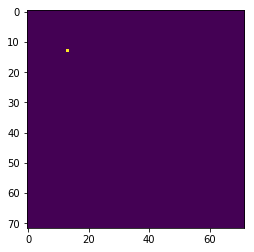

In [14]:
plt.imshow(sdml.get_mahalanobis_matrix())

## Distance learning with contrastive loss:

Define a simple neural network architecture. Better ones could also be investigated in future. 

In [15]:
from algorithms import contrastive_training

In [16]:
embedding_net_contrastive = contrastive_training(output_train, similarity_set, cuda, positive_weight=0.4, n_epochs=400, batch_size=32)

100%|██████████| 400/400 [00:33<00:00, 12.09it/s]


## Distance learning with triplet loss:

In [17]:
from algorithms import triplet_training

In [18]:
embedding_net_triplet = triplet_training(output_train, similarity_set, cuda, n_epochs=800)

100%|██████████| 800/800 [01:35<00:00,  8.20it/s]


# Evaluation of the different distances

First, we define an observation (i.e. a single simulation with its own parameter values) and a reference set from the test set. 

In [19]:
# the index of the test element to choose as an observation
index = 65

In [20]:
param1_obs = param1_test[index]
param2_obs = param2_test[index]
observation = test_data[index,:]
true_parameters = np.array([param1_obs, param2_obs])

In [21]:
output_ref = test_data[np.arange(len(test_labels))!=index]
param1_ref = param1_test[np.arange(len(test_labels))!=index]
param2_ref = param2_test[np.arange(len(test_labels))!=index]

We transform now the test set, with all possible techniques we considered: 

In [22]:
# SDML
observation_sdml = sdml.transform([observation])[0]
output_ref_sdml = sdml.transform(output_ref)

In [23]:
# Contrastive
observation_contrastive = embedding_net_contrastive(torch.from_numpy(observation.astype("float32")).to(device)).cpu().detach().numpy()
output_ref_contrastive = embedding_net_contrastive(torch.from_numpy(output_ref.astype("float32")).to(device)).cpu().detach().numpy()

In [24]:
# Triplet
observation_triplet = embedding_net_triplet(torch.from_numpy(observation.astype("float32")).to(device)).cpu().detach().numpy()
output_ref_triplet = embedding_net_triplet(torch.from_numpy(output_ref.astype("float32")).to(device)).cpu().detach().numpy()

## Plot of the distances with respect to a single observation

We use the held-out observation from before. 

As our data is not defined on a grid, we adapted the code from: https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/irregulardatagrid.html to produce contour plots. 

In [25]:
from utilities import contour_plot_no_grid

Compute now the distances

In [26]:
n_samples_ref = len(param1_ref)

true_distances = np.zeros((n_samples_ref))
naive_distances = np.zeros((n_samples_ref))
sdml_distances = np.zeros((n_samples_ref))
contrastive_distances = np.zeros((n_samples_ref))
triplet_distances = np.zeros((n_samples_ref))

for i in tqdm(range(n_samples_ref)):
        true_distances[i] = dist2(np.array([param1_ref[i], param2_ref[i]]), np.array([param1_obs, param2_obs]))
        naive_distances[i] = dist2(output_ref[i], observation)
        sdml_distances[i] = dist2(output_ref_sdml[i], observation_sdml)
        contrastive_distances[i] = dist2(output_ref_contrastive[i], observation_contrastive)
        triplet_distances[i] = dist2(output_ref_triplet[i], observation_triplet)

100%|██████████| 99/99 [00:00<00:00, 22408.86it/s]


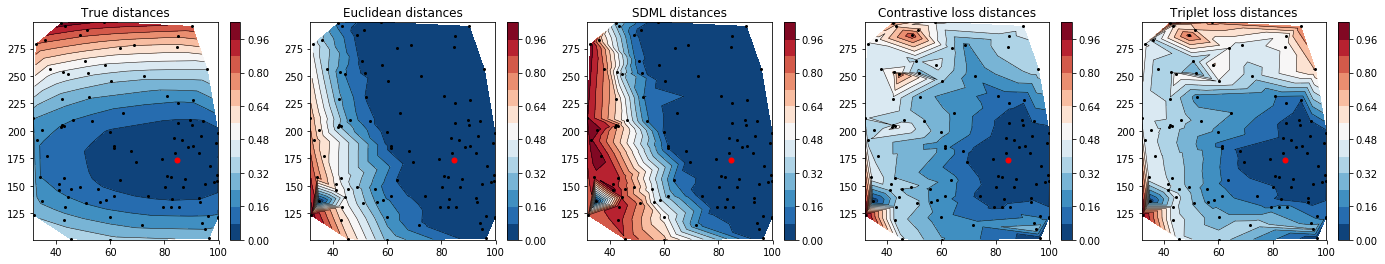

In [27]:
def rescale(distances):
    return distances/np.max(distances)

true_parameters = np.array([param1_obs, param2_obs])
log = False
show_train_points = True

fig, ax = plt.subplots(ncols=5, figsize=(24,4))
ax[0].set_title("True distances")
ax[1].set_title("Euclidean distances")
ax[2].set_title("SDML distances")
ax[3].set_title("Contrastive loss distances")
ax[4].set_title("Triplet loss distances")
contour_plot_no_grid(param2_ref, param1_ref, rescale(np.transpose(true_distances)), true_parameters[::-1], ax=ax[0], log=log, show_train_points=show_train_points, colorbar=True, fig=fig)
contour_plot_no_grid(param2_ref, param1_ref, rescale(np.transpose(naive_distances)), true_parameters[::-1], ax=ax[1], log=log, show_train_points=show_train_points, colorbar=True, fig=fig)
contour_plot_no_grid(param2_ref, param1_ref, rescale(np.transpose(sdml_distances)), true_parameters[::-1], ax=ax[2], log=log, show_train_points=show_train_points, colorbar=True, fig=fig)
contour_plot_no_grid(param2_ref, param1_ref, rescale(np.transpose(contrastive_distances)), true_parameters[::-1], ax=ax[3], log=log, show_train_points=show_train_points, colorbar=True, fig=fig)
contour_plot_no_grid(param2_ref, param1_ref, rescale(np.transpose(triplet_distances)), true_parameters[::-1], ax=ax[4], log=log, show_train_points=show_train_points, colorbar=True, fig=fig)

In [28]:
true_parameters

array([173.87405468,  84.55441241])

The neural-network based distances concentrate much better around the true value. It is not clear from here whether the contrastive or triplet loss is better, but from the below experiments the triplet turns out to be better. 

# Cross validation
## Distance from the train point with smaller embedded distance. 
We rely here on the results from the `cross_validation_script.py` script. 

In [29]:
parameter_distances_true = np.load("cross-valid-results/true_param_distances.npy")
parameter_distances_naive = np.load("cross-valid-results/naive_param_distances.npy")
parameter_distances_sdml = np.load("cross-valid-results/sdml_param_distances.npy")
parameter_distances_contrastive = np.load("cross-valid-results/contrastive_batch32_epochs400_param_distances.npy")
parameter_distances_triplet = np.load("cross-valid-results/triplet_batch16_epochs800_param_distances.npy")

First (second) row corresponds to the first (second) parameter. These are histograms representing the distance between the true parameter of the observation example, with respect to the parameter estimated as the one with the smaller learned distance, amongst the reference ones. The distance has been learned by using the 300 training examples. 

The histograms are done in a Leave-One-Out cross validation framework, i.e. for each possible sample in the test dataset, it is taken as an observation once, while all the others serve as reference. Therefore the histograms are done over 100 different realization. 

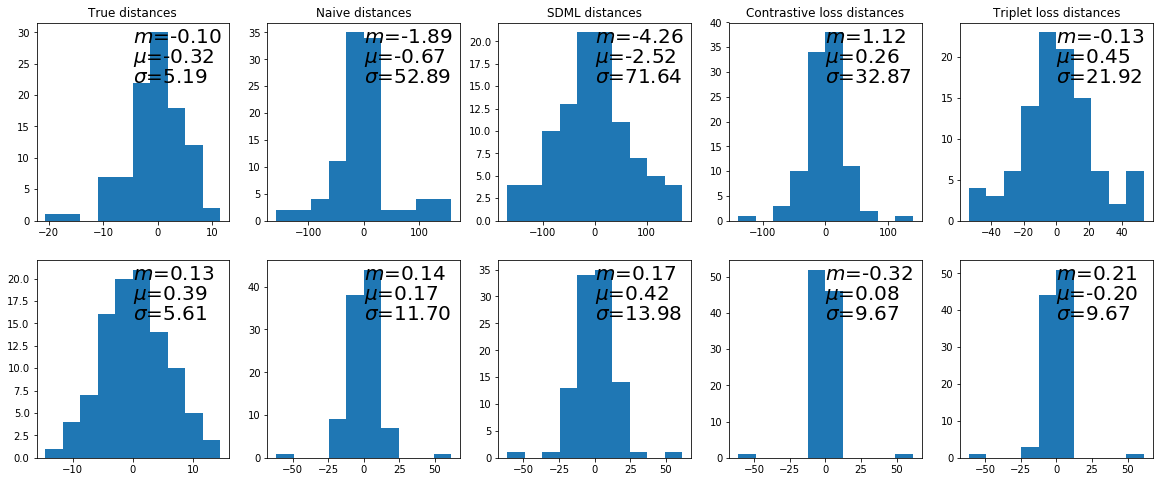

In [30]:
def write_mean_std(ax, vector):
    # exclude the nan elements
    ax.text(0.5, 0.9, r"$m$={:.2f}".format(np.median(vector[np.isfinite(vector)])), size=20, transform=ax.transAxes)
    ax.text(0.5, 0.8, r"$\mu$={:.2f}".format(np.mean(vector[np.isfinite(vector)])), size=20, transform=ax.transAxes)
    ax.text(0.5, 0.7, r"$\sigma$={:.2f}".format(np.std(vector[np.isfinite(vector)])), size=20, transform=ax.transAxes)

def plot_hist(ax, vector):
    ax.hist(np.array(vector))
    
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20,8))
ax[0,0].set_title("True distances")
ax[0,1].set_title("Naive distances")
ax[0,2].set_title("SDML distances")
ax[0,3].set_title("Contrastive loss distances")
ax[0,4].set_title("Triplet loss distances")

write_mean_std(ax[0,0], parameter_distances_true[:,0]); plot_hist(ax[0,0], parameter_distances_true[:,0])
write_mean_std(ax[1,0], parameter_distances_true[:,1]); plot_hist(ax[1,0], parameter_distances_true[:,1])
write_mean_std(ax[0,1], parameter_distances_naive[:,0]); plot_hist(ax[0,1], parameter_distances_naive[:,0])
write_mean_std(ax[1,1], parameter_distances_naive[:,1]); plot_hist(ax[1,1], parameter_distances_naive[:,1])
write_mean_std(ax[0,2], parameter_distances_sdml[:,0]); plot_hist(ax[0,2], parameter_distances_sdml[:,0])
write_mean_std(ax[1,2], parameter_distances_sdml[:,1]); plot_hist(ax[1,2], parameter_distances_sdml[:,1])
write_mean_std(ax[0,3], parameter_distances_contrastive[:,0]); plot_hist(ax[0,3], parameter_distances_contrastive[:,0])
write_mean_std(ax[1,3], parameter_distances_contrastive[:,1]); plot_hist(ax[1,3], parameter_distances_contrastive[:,1])
write_mean_std(ax[0,4], parameter_distances_triplet[:,0]); plot_hist(ax[0,4], parameter_distances_triplet[:,0])
write_mean_std(ax[1,4], parameter_distances_triplet[:,1]); plot_hist(ax[1,4], parameter_distances_triplet[:,1])

Note that all of the estimates seem to be mostly unbiased, and that is good. The techniques for which the histograms are narrower ones should be better in a sense.

Arguably, using a simple estimate as the point with the minimum distance is not fully representative of the behaviour of the ABC setting. For instance, you can see that the estimate given by the naive distances are very unbiased and have very small standard deviation; however, if you check the graphs of the distances, they are not very concentrated around the true value.



## Estimate divergence between the distribution induced by the learned distance function in parameter space and the one induced by the true distance

We consider first Kullback-Leibler distance, and estimate it in a importance weight fashion. We denote as $P$ the distribution with density $p(\theta) \propto e^{-d(\theta)}$ induced by the learned distance $d(\theta)$ (neglecting here the fact that actually that is not simply a function of the parameter space, but a function of the data generatedd by that parameter value. We denote instead by $d^*(\theta)$ the true distance and by $P*$ the distribution with density $p^*(\theta) \propto e^{-d^*(\theta)}$.

We want to estimate in some way $D_{KL} (P||P^*) $. Recall the definition: 

$$D_{KL}(P||P^*) = \int p(\theta) \log \left( \frac{p(\theta)}{p^*(\theta)} \right) d\theta;$$

we consider here an importance sample estimate. We write therefore $D_{KL}(P||P^*) = \int q(\theta) \frac{p(\theta)}{q(\theta)} \log \left( \frac{p(\theta)}{p^*(\theta)} \right) d\theta$, where $q$ is the density according to which our samples are drawn. Then, we can estimate the above by: 

$$\hat D_{KL}(P||P^*) = \sum_{i=1}^n w_i \cdot \log \left( \frac{p(\theta)}{p^*(\theta)} \right),  \quad w_i =\frac{1}{n} \frac{p(\theta_i)}{q(\theta_i)}, \quad \theta_i \sim q. $$

Again, we cannot compute $w_i$ as we do not know the normalization constants. Then we define $p(\theta) = \tilde p(\theta) /Z$ and $p^*(\theta) = \tilde p^*(\theta) /Z^*$.

We use therefore the following importance weight: 

$$ P_i = \frac{p(\theta_i)/q(\theta_i)}{\sum_{j=1}^n p(\theta_j)/q(\theta_j)} = \frac{\tilde p(\theta_i)/q(\theta_i)}{\sum_{j=1}^n \tilde p(\theta_j)/q(\theta_j)}, $$

where $\hat Z = \frac{1}{n} \sum_{i=1}^n \frac{\tilde p(\theta_i)}{q(\theta_i)}$ is an estimator of $Z$, and similarly $\hat Z^* = \frac{1}{n} \sum_{i=1}^n \frac{\tilde p^*(\theta_i)}{q(\theta_i)}$ is an estimator of $Z^*$.

We are then left with the following estimator: 

$$\hat D_{KL}(P||P^*) = \sum_{i=1}^n \frac{\tilde p(\theta_i)/q(\theta_i)}{\hat Z} \cdot \left( \log\frac{\hat Z^*}{\hat Z} + d^*(\theta_i) - d(\theta_i)     \right)  , \quad \theta_i \sim q, $$
where we have used the explicit dependence of $p$ and $p^*$ on the distance function. 

Note that, in our specific case here, $q$ is a uniform distribution.

We also present here graphs for the Total Variation (TV) distance, even if they are not present in the paper. In fact, they more or less convey the same information. Also, the technique in which they are computed is quite similar to the KL setting. 

The histograms are produced in the same Leave-One-Out cross validation framework as described above, with the training performed on the 300 samples of the train set.

We rely on the results from the `divergence_script.py` script:

In [31]:
KL_IS_true = np.load("cross-valid-results/true_estimated_KL_IS_distance_functions.npy")
KL_IS_naive = np.load("cross-valid-results/naive_estimated_KL_IS_distance_functions.npy")
KL_IS_sdml = np.load("cross-valid-results/sdml_estimated_KL_IS_distance_functions.npy")
KL_IS_contrastive = np.load("cross-valid-results/contrastive_batch32_epochs400_estimated_KL_IS_distance_functions.npy")
KL_IS_triplet = np.load("cross-valid-results/triplet_batch16_epochs800_estimated_KL_IS_distance_functions.npy")

TV_IS_true = np.load("cross-valid-results/true_estimated_TV_IS_distance_functions.npy")
TV_IS_naive = np.load("cross-valid-results/naive_estimated_TV_IS_distance_functions.npy")
TV_IS_sdml = np.load("cross-valid-results/sdml_estimated_TV_IS_distance_functions.npy")
TV_IS_contrastive = np.load("cross-valid-results/contrastive_batch32_epochs400_estimated_TV_IS_distance_functions.npy")
TV_IS_triplet = np.load("cross-valid-results/triplet_batch16_epochs800_estimated_TV_IS_distance_functions.npy")

The numerical value of the results depend very much on the value of beta you use in the definition of the distribution.

In the plot, first row is the estimated KL distance, the second is the total variation distance. 

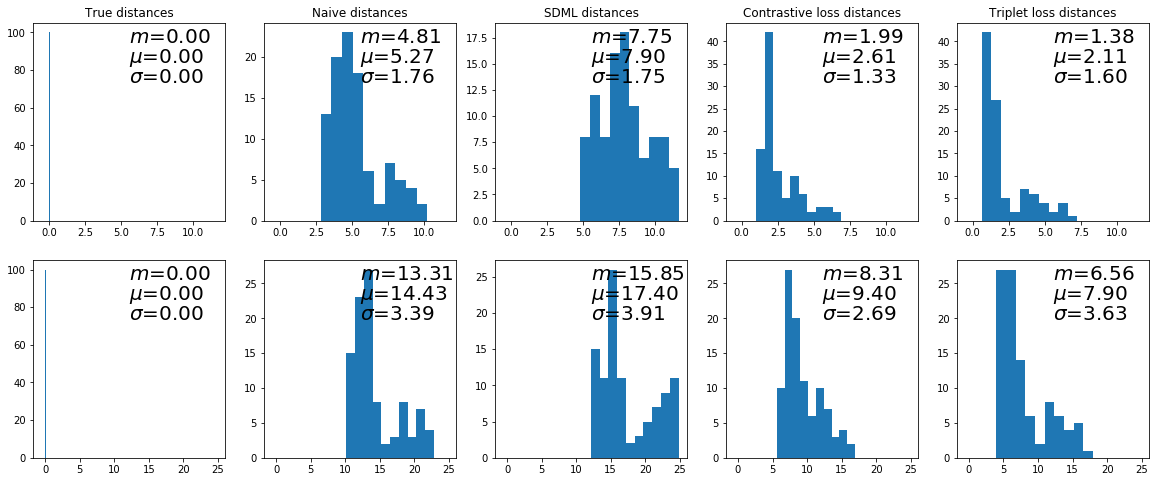

In [32]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20,8), sharex='row')
ax[0,0].set_title("True distances")
ax[0,1].set_title("Naive distances")
ax[0,2].set_title("SDML distances")
ax[0,3].set_title("Contrastive loss distances")
ax[0,4].set_title("Triplet loss distances")

write_mean_std(ax[0,0], KL_IS_true); plot_hist(ax[0,0], KL_IS_true)
write_mean_std(ax[0,1], KL_IS_naive); plot_hist(ax[0,1], KL_IS_naive)
write_mean_std(ax[0,2], KL_IS_sdml); plot_hist(ax[0,2], KL_IS_sdml)
write_mean_std(ax[0,3], KL_IS_contrastive); plot_hist(ax[0,3], KL_IS_contrastive)
write_mean_std(ax[0,4], KL_IS_triplet); plot_hist(ax[0,4], KL_IS_triplet)

write_mean_std(ax[1,0], TV_IS_true); plot_hist(ax[1,0], TV_IS_true)
write_mean_std(ax[1,1], TV_IS_naive); plot_hist(ax[1,1], TV_IS_naive)
write_mean_std(ax[1,2], TV_IS_sdml); plot_hist(ax[1,2], TV_IS_sdml)
write_mean_std(ax[1,3], TV_IS_contrastive); plot_hist(ax[1,3], TV_IS_contrastive)
write_mean_std(ax[1,4], TV_IS_triplet); plot_hist(ax[1,4], TV_IS_triplet)

It may happen that in some cases the estimate of the KL is negative. This in due to the errors in the estimator, and it means that the distance was small for that case.

For this measure, it seems that the triplet loss is best.

# Sensitivity study of the distance learning techniques with respect to the choice of the quantile in defining the similarity set. 

We consider the mean and standard deviation of the estimated KL divergence over the possible test LeaveOneOut splits. We do this for SDML, contrastive and triplet loss and for the following choice of epsilon: 

In [33]:
epsilon_values = np.arange(0.02, 1.02, 0.02)

In [34]:
folder = "cross-valid-results/epsilon_sensitivity_study/"

KL_list_contr = []
KL_list_tripl = []
KL_list_sdml = []

epsilon_accepted_contr = []
epsilon_accepted_tripl = []
epsilon_accepted_sdml = []

for epsilon in epsilon_values:
    try:
        KL_divergence_contr = np.load(folder + "/" + 'contrastive_batch32_epochs400' + "_estimated_KL_IS_distance_functions" + "epsilon_{:.2f}".format(epsilon) + ".npy")
        KL_list_contr.append(KL_divergence_contr)
        epsilon_accepted_contr.append(epsilon)
    except FileNotFoundError:
        print("Epsilon {:.2f} not working for contrastive".format(epsilon))
        
    try:
        KL_divergence_tripl = np.load(folder + "/" + 'triplet_batch16_epochs800' + "_estimated_KL_IS_distance_functions" + "epsilon_{:.2f}".format(epsilon) + ".npy")
        KL_list_tripl.append(KL_divergence_tripl)
        epsilon_accepted_tripl.append(epsilon)
    except FileNotFoundError:
        print("Epsilon {:.2f} not working for triplet".format(epsilon))
    
    try:
        KL_divergence_sdml = np.load(folder + "/" + 'sdml' + "_estimated_KL_IS_distance_functions" + "epsilon_{:.2f}".format(epsilon) + ".npy")
        KL_list_sdml.append(KL_divergence_sdml)
        epsilon_accepted_sdml.append(epsilon)
    except FileNotFoundError:
        print("Epsilon {:.2f} not working for SDML".format(epsilon))
        
KL_list_contr = np.array(KL_list_contr).T
KL_list_tripl = np.array(KL_list_tripl).T
KL_list_sdml = np.array(KL_list_sdml).T

Epsilon 0.02 not working for SDML
Epsilon 0.04 not working for SDML
Epsilon 0.12 not working for SDML
Epsilon 0.24 not working for SDML
Epsilon 0.34 not working for SDML
Epsilon 0.36 not working for SDML
Epsilon 0.42 not working for SDML
Epsilon 0.46 not working for SDML
Epsilon 0.48 not working for SDML
Epsilon 0.56 not working for SDML
Epsilon 0.60 not working for SDML
Epsilon 0.76 not working for contrastive
Epsilon 0.76 not working for triplet
Epsilon 0.78 not working for contrastive
Epsilon 0.78 not working for triplet
Epsilon 0.78 not working for SDML
Epsilon 0.80 not working for contrastive
Epsilon 0.80 not working for triplet
Epsilon 0.82 not working for contrastive
Epsilon 0.82 not working for triplet
Epsilon 0.84 not working for contrastive
Epsilon 0.84 not working for triplet
Epsilon 0.86 not working for contrastive
Epsilon 0.86 not working for triplet
Epsilon 0.88 not working for contrastive
Epsilon 0.88 not working for triplet
Epsilon 0.88 not working for SDML
Epsilon 0.90

Note that SDML was not able to converge for some values of epsilon. 

Also, the contrastive and triplet did not work for epsilon larger than 0.74, probably because in this scenario there are some samples that are considered similar to all the others, and this gives issues in the training routines. However, this is not a problem, as you can see from the plots below that the performance gets worse for epsilon larger than 0.6. 

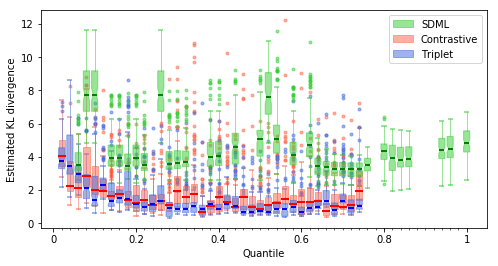

In [35]:
def set_colors(bp, color1, color2, alpha):

    for box in bp['boxes']:
        # change outline color
        box.set( color=color1, alpha=alpha)
        # change fill color
        #box.set( facecolor = '#1b9e77' )

    ## change color and linewidth of the whiskers
    for whisker in bp['whiskers']:
        whisker.set(color=color1, alpha=alpha)#, linewidth=2)

    ## change color and linewidth of the caps
    for cap in bp['caps']:
        cap.set(color=color1, linewidth=2, alpha=alpha)

    ## change color and linewidth of the medians
    for median in bp['medians']:
        median.set(color=color2, linewidth=2)
    
    ## change color and linewidth of the medians
    for mean in bp['means']:
        mean.set(color=color2, linewidth=2)

        
    ## change the style of fliers and their fill
    for flier in bp['fliers']:
        flier.set(marker='.', alpha=alpha, markerfacecolor=color1, markeredgecolor=color1)
        
alpha = 0.5
contr_color1 = 'tomato'
contr_color2 = 'red' 
tripl_color1 = 'royalblue'
tripl_color2 = 'blue' 
sdml_color1 = 'limegreen'
sdml_color2 = 'green' 
mean = False

# plt.figure()
fig, ax = plt.subplots(figsize=(8,4))

bp_contr = ax.boxplot(KL_list_contr, notch=False, showmeans=mean, meanline=True, showfliers=True, patch_artist=True,
                positions=epsilon_accepted_contr, widths = 0.015, )
set_colors(bp_contr, contr_color1, contr_color2, alpha)
    
bp_tripl = ax.boxplot(KL_list_tripl, notch=True, showmeans=mean, meanline=True, showfliers=True, patch_artist=True,
                  positions=epsilon_accepted_tripl, widths = 0.015, )
set_colors(bp_tripl, tripl_color1, tripl_color2, alpha)

bp_sdml = ax.boxplot(KL_list_sdml, notch=True, showmeans=mean, meanline=True, showfliers=True, patch_artist=True,
                  positions=epsilon_accepted_sdml, widths = 0.015, )
set_colors(bp_sdml, sdml_color1, sdml_color2, alpha)

ax.legend([bp_sdml["boxes"][0], bp_contr["boxes"][0], bp_tripl["boxes"][0]],
          ['SDML', 'Contrastive', 'Triplet'])

ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_xticks(epsilon_values, minor = True)
ax.set_xlim([-0.03,1.05])
ax.set_ylabel("Estimated KL divergence")
ax.set_xlabel("Quantile")
plt.show()

You can see that SDML performs always bad, and that the contrastive is always worse than triplet. 

We choose as final value of epsilon the one for which the median of the estimated KL over the splits is smaller. 

In [36]:
best_epsilon = epsilon_accepted_tripl[np.argmin(np.median(KL_list_tripl, axis=0))]
best_epsilon

0.6

It is quite surprising that triplet (and contrastive as well) are able to capture more information when more than half of the possible pairs of samples are considered similar. This requires further investigation. 

# Now investigate the Semiautomatic NN summary statistics learning with respect to triplet with the above best epsilon

You can see that the triplet performs slightly better, but however Semiautomatic NN is also quite good.

We show the distance contour with respect to the observation used above, as well as the divergence histogram. 

In [37]:
embedding_distances_FP_nn = np.load("cross-valid-results/FP_nn_epochs400_embedding_distances.npy")
embedding_distances_triplet_best_eps = np.load("cross-valid-results/epsilon_sensitivity_study/"
                                               "triplet_batch16_epochs800_embedding_distances"
                                               + "epsilon_{:.2f}".format(best_epsilon) + ".npy")

distances_FP_nn = embedding_distances_FP_nn[index]
distances_triplet_best_eps = embedding_distances_triplet_best_eps[index]

In [38]:
KL_IS_FP_nn = np.load("cross-valid-results/FP_nn_epochs400_estimated_KL_IS_distance_functions.npy")
KL_IS_triplet_best_eps = np.load("cross-valid-results/epsilon_sensitivity_study/"
                                 "triplet_batch16_epochs800_estimated_KL_IS_distance_functions"
                                 + "epsilon_{:.2f}".format(best_epsilon) + ".npy")

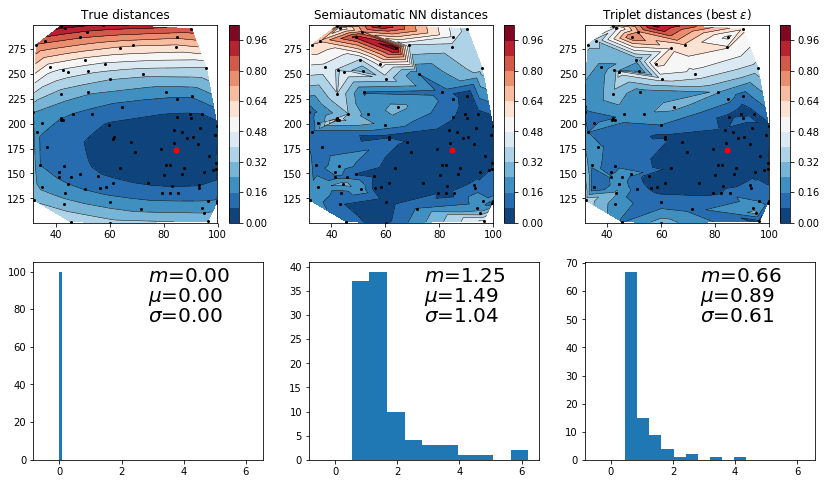

In [39]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(14,8), sharex='row')
ax[0,0].set_title("True distances")
ax[0,1].set_title("Semiautomatic NN distances")
ax[0,2].set_title(r"Triplet distances (best $\epsilon$)")
contour_plot_no_grid(param2_ref, param1_ref, rescale(np.transpose(true_distances)), true_parameters[::-1], ax=ax[0,0], log=log, show_train_points=show_train_points, colorbar=True, fig=fig)
contour_plot_no_grid(param2_ref, param1_ref, rescale(np.transpose(distances_FP_nn)), true_parameters[::-1], ax=ax[0,1], log=log, show_train_points=show_train_points, colorbar=True, fig=fig)
contour_plot_no_grid(param2_ref, param1_ref, rescale(np.transpose(distances_triplet_best_eps)), true_parameters[::-1], ax=ax[0,2], log=log, show_train_points=show_train_points, colorbar=True, fig=fig)

write_mean_std(ax[1,0], KL_IS_true); plot_hist(ax[1,0], KL_IS_true)
write_mean_std(ax[1,1], KL_IS_FP_nn); plot_hist(ax[1,1], KL_IS_FP_nn)
write_mean_std(ax[1,2], KL_IS_triplet_best_eps); plot_hist(ax[1,2], KL_IS_triplet_best_eps)

We believe that the distance learning approach has a lot of space for improvements; specifically, in future work we will investigate moire advanced distance learning approaches. Note that the approach of considering only similarity set is quite a large loss of information in this case where the ground truth distance is known.